# Dataset Splitting

In this Notebook the Split of the dataset is conducted. Different Annotation files are created but they all use the same split ratio with the same methods so the split assciation is equal for every model.

In [2]:
import json
import copy
import random 
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from PIL import Image

random.seed(42)

In [3]:
# load data
with open('../00_Dataset/annotations.json') as f:
    data = json.load(f)

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

test_only_clips = [("Video_6","clip_1")]

## Entire Dataset Split

In [4]:
# create a copy of the data
entire_dataset = copy.deepcopy(data)

def assign_splits(dataset):
    for subset in dataset["subsets"]:
        for video in subset["videos"]:
                num_frames = 0
                
                for clip in video['clips']:
                    num_frames += len(clip['frames_with_objects'].keys())+1

                num_train = int(num_frames * train_ratio)
                num_validation = int(num_frames * validation_ratio)
                num_test = num_frames - num_train - num_validation
                
                for clip in video['clips']:
                    for frame_number, frame in clip['frames_with_objects'].items():
                        if num_train > 0:
                            frame['split'] = 'train'
                            num_train -= 1
                        elif num_validation > 0:
                            frame['split'] = 'validation'
                            num_validation -= 1
                        elif num_test > 0:
                            frame['split'] = 'test'
                            num_test -= 1
                        else:
                            frame['split'] = 'none'

                        # manage special test clips
                        if (video['name'], clip['name']) in test_only_clips:
                            frame['split'] = 'test'

    return dataset

def count_splits(dataset):
    # count frames for each split and each subset
    dict={}
    for subset in dataset["subsets"]:
        dict[subset["name"]] = {"train": 0, "validation": 0, "test": 0}
        for video in subset["videos"]:
            for clip in video['clips']:
                for frame_number, frame in clip['frames_with_objects'].items():
                    dict[subset["name"]][frame['split']] += 1

    for subset in dataset["subsets"]:
        total = sum(dict[subset["name"]].values())
        print(f"Subset: {subset['name']}")
        for split in dict[subset["name"]]:
            # print total amount and ratio
            print(f"Split: {split}, total frames: {dict[subset['name']][split]}, ratio: {dict[subset['name']][split]/total}")
        print()


# assign splits
entire_dataset = assign_splits(entire_dataset)

# count splits
count_splits(entire_dataset)

# safe annotations
with open('../00_Dataset/annotations_complete.json', 'w') as f:
    json.dump(entire_dataset, f, indent=1)

Subset: Amateur
Split: train, total frames: 7889, ratio: 0.6835629494844467
Split: validation, total frames: 1689, ratio: 0.1463478034832337
Split: test, total frames: 1963, ratio: 0.17008924703231956

Subset: TrackNet
Split: train, total frames: 13947, ratio: 0.7031509957146458
Split: validation, total frames: 2984, ratio: 0.1504411394000504
Split: test, total frames: 2904, ratio: 0.14640786488530375

Subset: Court
Split: train, total frames: 6312, ratio: 0.7139463861554123
Split: validation, total frames: 1164, ratio: 0.13165931455717678
Split: test, total frames: 1365, ratio: 0.1543942992874109



## Ball Tracking Split

In [5]:
# create a copy of the data
ball_dataset = copy.deepcopy(data)

# assign splits
ball_dataset = assign_splits(ball_dataset)

# remove all non clay court games 
games_to_keep = ["game4", "game6", "game8"]

for subset in ball_dataset["subsets"]:
    if subset["name"] == "TrackNet":
        subset["videos"] = [video for video in subset["videos"] if video["name"] in games_to_keep]

#remove third dataset by index
ball_dataset["subsets"].pop(2)

# count splits
count_splits(ball_dataset)

# safe annotations
with open('../00_Dataset/annotations_ball.json', 'w') as f:
    json.dump(ball_dataset, f, indent=1)

Subset: Amateur
Split: train, total frames: 7889, ratio: 0.6835629494844467
Split: validation, total frames: 1689, ratio: 0.1463478034832337
Split: test, total frames: 1963, ratio: 0.17008924703231956

Subset: TrackNet
Split: train, total frames: 4342, ratio: 0.7020210185933711
Split: validation, total frames: 929, ratio: 0.1502021018593371
Split: test, total frames: 914, ratio: 0.14777687954729182



## Split for Court detection

### Clustering

Clustering to extract court color to filter for only clay courts

In [6]:
def extract_dominant_color(image_path):
    # Open the image
    image = Image.open(image_path)
    
    # Convert the image to RGB (in case it's not already in RGB mode)
    image = image.convert("RGB")
    
    # Get image dimensions
    width, height = image.size
    
    # Define the center region (e.g., a 200x200 square in the center)
    center_x, center_y = width // 2, height // 2
    region_size = 100  # Size of the center region for sampling
    
    # Define the bounds of the center region
    left = max(center_x - region_size // 2, 0)
    upper = max(center_y - region_size // 2, 0)
    right = min(center_x + region_size // 2, width)
    lower = min(center_y + region_size // 2, height)
    
    # Crop the center region and get pixel data as a NumPy array
    center_region = image.crop((left, upper, right, lower))
    center_pixels = np.array(center_region)
    
    # Flatten the pixel array and randomly select 100 pixels
    center_pixels_flat = center_pixels.reshape(-1, 3)
    sampled_pixels = random.choices(center_pixels_flat, k=100)
    
    # Count the most common color among the sampled pixels
    color_counts = Counter(map(tuple, sampled_pixels))
    dominant_color = color_counts.most_common(1)[0][0]
    
    return dominant_color

def classify_court(image_path, kmeans, cluster_centers):
    # Extract the dominant color from the image
    dominant_color = extract_dominant_color(image_path)
    
    # add feature names
    features = ["red", "green", "blue"]
    # create dataframe
    color_df = pd.DataFrame(columns=features)
    # add dominant color to dataframe
    color_df = pd.concat([color_df, pd.DataFrame({"red": [dominant_color[0]], "green": [dominant_color[1]], "blue": [dominant_color[2]]})], ignore_index=True)

    # Classify the dominant color using the KMeans model
    label = kmeans.predict(color_df)
    
    # return color and label
    return cluster_centers[label[0]], label[0]

# create dataset from counter
def create_dataset(color_counter):
    # Create a DataFrame from the color counter
    df = pd.DataFrame(columns=["red", "green", "blue"])

    # loop over counter
    for color, count in color_counter.items():
        # append color count times
        for _ in range(count):
            # add row to dataframe using concat
            df = pd.concat([df, pd.DataFrame({"red": [color[0]], "green": [color[1]], "blue": [color[2]]})], ignore_index=True)
    
    return df

def calculate_average_color(colors):
    # colors is an array of multiple colors arrays
    # calculate the average color
    avg_color = tuple(np.mean(colors, axis=0))
    return avg_color

def process_images_in_folder(folder_path):
    color_counter = Counter()

    # Collect all file paths from the folder and subfolders
    all_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            all_files.append(os.path.join(root, file))

    # Initialize a tqdm progress bar for all files
    with tqdm(total=len(all_files), desc="Processing images") as pbar:
        for file_path in all_files:
            if file_path.endswith(".jpg"):  # Process only .jpg files
                dominant_color = extract_dominant_color(file_path)
                color_counter[dominant_color] += 1  # Count each dominant color
            else:
                print(f"Skipping file {file_path} as it is not a .jpg file")
            pbar.update(1)  # Update the progress bar

    return color_counter

def show_color_centers(cluster_centers):
    # Create a plot for the color centers
    plt.figure(figsize=(8, 2))
    
    # Plot each cluster center as a color patch
    for i, color in enumerate(cluster_centers):
        plt.subplot(1, len(cluster_centers), i + 1)
        plt.imshow([[color / 255]], aspect='auto')  # Divide by 255 to normalize RGB values to [0, 1]
        plt.axis('off')
        plt.title(f'Cluster {i + 1}')
    
    plt.show()

In [7]:
counts = process_images_in_folder("../00_Dataset/Court")
color_df = create_dataset(counts)
color_df.head()

Processing images: 100%|██████████| 8841/8841 [01:49<00:00, 80.85it/s]


,red,green,blue
0,92,75,120
1,92,75,120
2,90,76,120
3,92,78,122
4,92,78,122


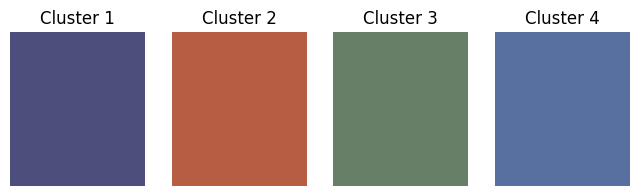

In [8]:
k= 4
# Train a KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(color_df)
cluster_centers = kmeans.cluster_centers_

# Show the color centers
show_color_centers(cluster_centers)

In [9]:
data_court = copy.deepcopy(data)

for video in data_court['subsets'][2]['videos']:
    colors = []
    labels = []
    for clip in video['clips']:
        for key,frame in clip['frames_with_objects'].items():
            image_path = f"../00_Dataset/Court/{video['name']}/Clip1/{key}.jpg"
            color, label = classify_court(image_path, kmeans, cluster_centers)
            colors.append(color)
            labels.append(label)

    # calculate mode label
    mode_label = max(set(labels), key=labels.count)
    # calculate the average color
    average_color = calculate_average_color(colors)

    # update video
    video['average_color'] = average_color
    video['mode_label'] = int(mode_label)

In [10]:
# remove subset 1
removed = data_court["subsets"].pop(1)

# loop over subset 0 and keep only every 50th frame
for video in data_court["subsets"][0]["videos"]:
    for clip in video["clips"]:
        frames = list(clip["frames_with_objects"].keys())
        for frame in frames:
            if int(frame) % 50 != 0:
                del clip["frames_with_objects"][frame]

# loop over subset 1 and remove every video with a mode_label than 1
videos_to_remove = []
for video in data_court["subsets"][1]["videos"]:
    if video["mode_label"] != 1:
        videos_to_remove.append(video)

for video in videos_to_remove:
    data_court["subsets"][1]["videos"].remove(video)

# count frames for each subset
dict={}
for subset in data_court["subsets"]:
    dict[subset["name"]] = 0
    for video in subset["videos"]:
        for clip in video['clips']:
            dict[subset["name"]] += len(clip['frames_with_objects'].keys())

dict

{'Amateur': 247, 'Court': 1151}

### Create Splits

In [11]:
# assign splits
data_court = assign_splits(data_court)

# count splits
count_splits(data_court)

# safe annotations
with open('../00_Dataset/annotations_court.json', 'w') as f:
    json.dump(data_court, f, indent=1)

Subset: Amateur
Split: train, total frames: 191, ratio: 0.7732793522267206
Split: validation, total frames: 38, ratio: 0.15384615384615385
Split: test, total frames: 18, ratio: 0.0728744939271255

Subset: Court
Split: train, total frames: 837, ratio: 0.7271937445699392
Split: validation, total frames: 136, ratio: 0.11815812337098175
Split: test, total frames: 178, ratio: 0.15464813205907907



## Split for Player Tracking

In [12]:
# create a copy of the data
player_dataset = copy.deepcopy(data)

# assign splits
player_dataset = assign_splits(player_dataset)

# remove all subsets exept first
player_dataset["subsets"].pop(1)
player_dataset["subsets"].pop(1)

# count splits
count_splits(player_dataset)

# safe annotations
with open('../00_Dataset/annotations_player.json', 'w') as f:
    json.dump(player_dataset, f, indent=1)

Subset: Amateur
Split: train, total frames: 7889, ratio: 0.6835629494844467
Split: validation, total frames: 1689, ratio: 0.1463478034832337
Split: test, total frames: 1963, ratio: 0.17008924703231956



## Split for bounce and hit detection

In [13]:
# create a copy of the data
bounce_dataset = copy.deepcopy(data)

# assign splits
bounce_dataset = assign_splits(bounce_dataset)

#remove third dataset by index
bounce_dataset["subsets"].pop(2)

# count splits
count_splits(bounce_dataset)

# safe annotations
with open('../00_Dataset/annotations_bounce.json', 'w') as f:
    json.dump(bounce_dataset, f, indent=1)

Subset: Amateur
Split: train, total frames: 7889, ratio: 0.6835629494844467
Split: validation, total frames: 1689, ratio: 0.1463478034832337
Split: test, total frames: 1963, ratio: 0.17008924703231956

Subset: TrackNet
Split: train, total frames: 13947, ratio: 0.7031509957146458
Split: validation, total frames: 2984, ratio: 0.1504411394000504
Split: test, total frames: 2904, ratio: 0.14640786488530375

